# Project Bike Rental 
Feature importance for registered bike rental users

### Step 1. Import libraries and data

In [38]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import statsmodels.api as sm
from warnings import simplefilter
simplefilter(action='ignore', category=(FutureWarning, RuntimeWarning)) 

In [2]:
df = pd.read_csv('hour.csv')

### Step 2. Exploratory data analysis

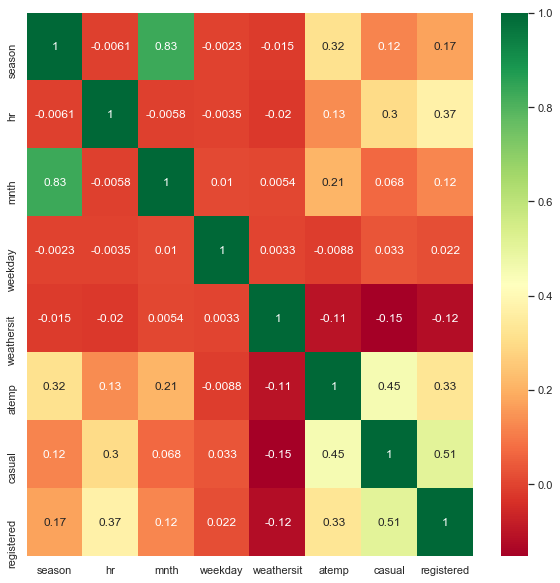

In [30]:
# heatmap showing correlation between features
df_feat_correl = df.loc[:, ['season', 'hr','mnth', 'weekday', 
                                 'weathersit', 'atemp', 'casual', 'registered']
                            ]
corrmat = df_feat_correl.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(10,10))
g = sns.heatmap(df_feat_correl[top_corr_features].corr(),annot=True,cmap="RdYlGn")
plt.savefig('Correlation_heatmap.png')

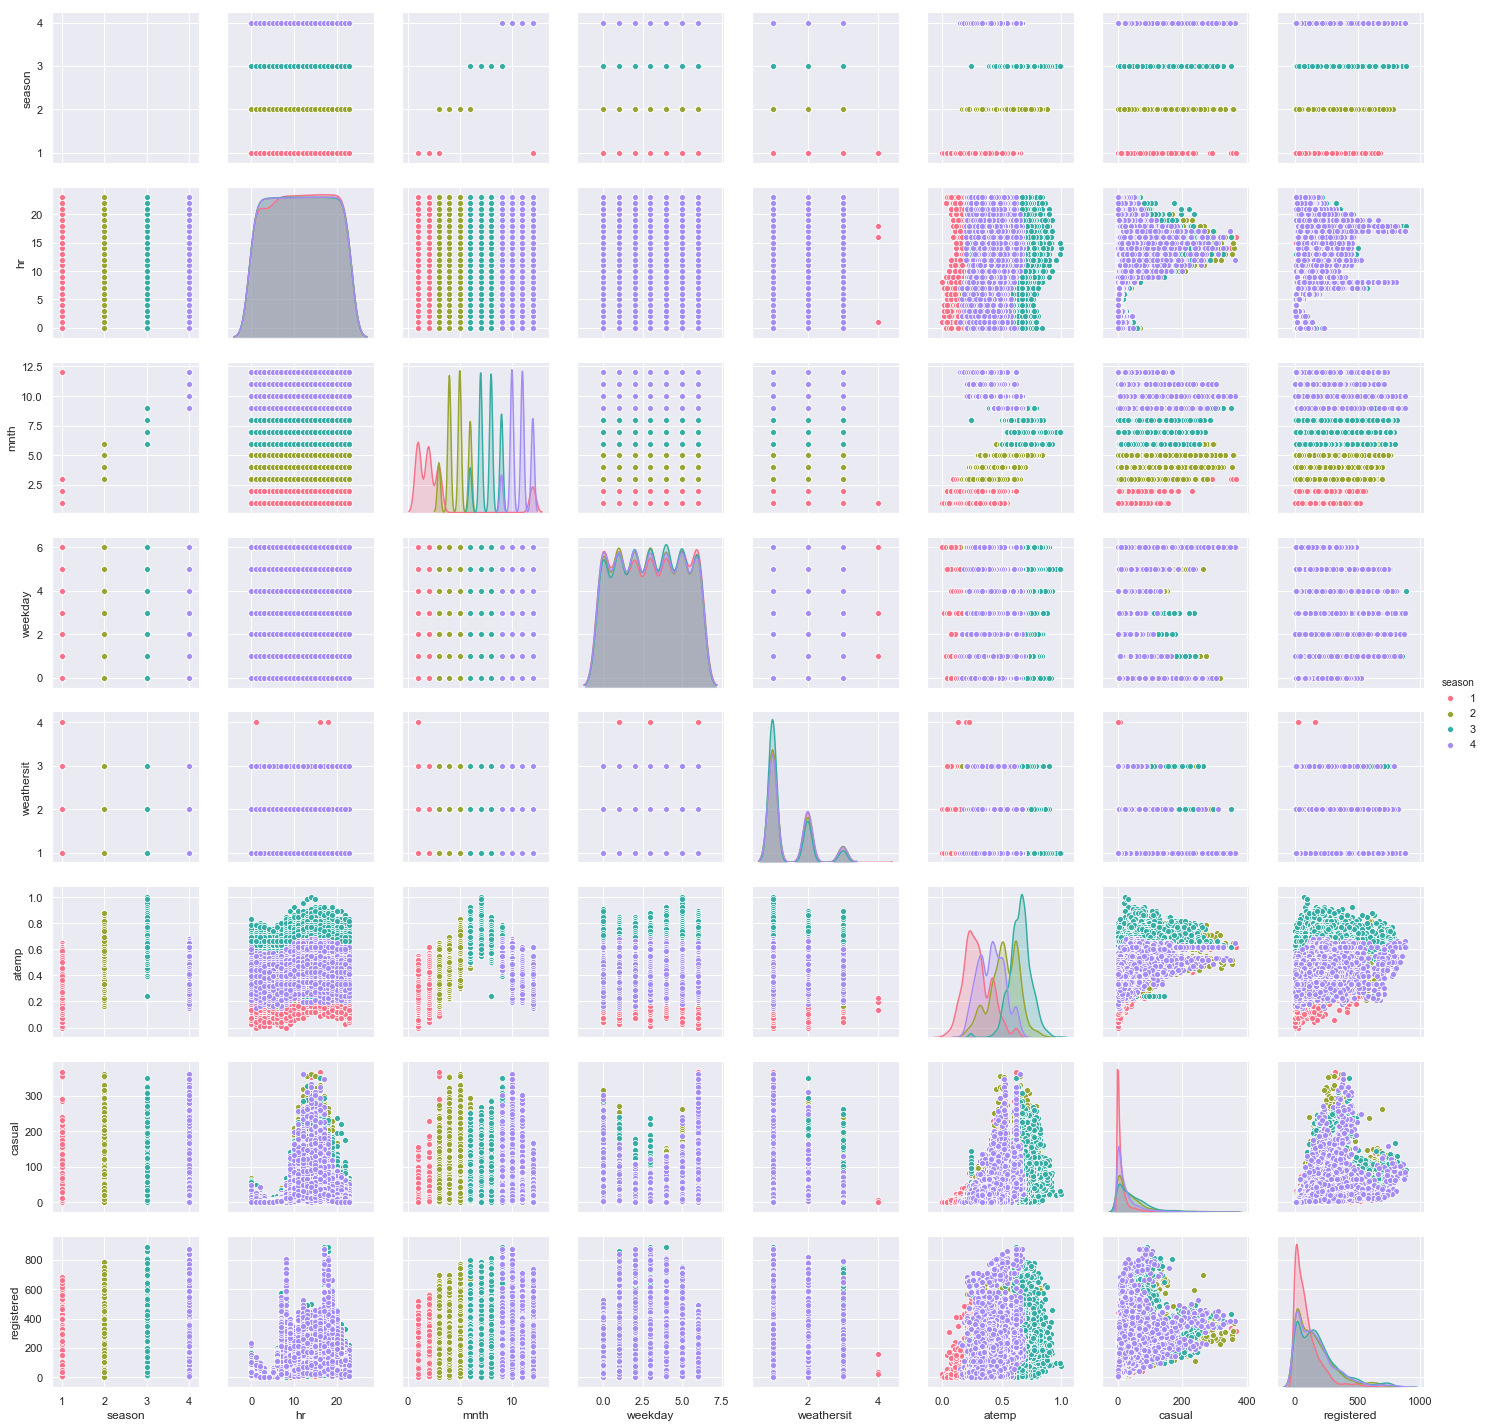

In [32]:
# Pairplot showing correalting between features, categorized by season 
sns.set(font_scale = 1)
pairplot = sns.pairplot(df_feat_correl, hue='season', palette= 'husl')
plt.savefig('Correlaion_pairplot.png')

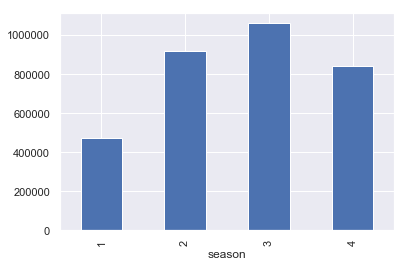

In [5]:
# Zoom-in to rentals per season - unequal intervals between seasons, non-ordinal feature
df.groupby(df['season']).sum()['cnt'].plot.bar()

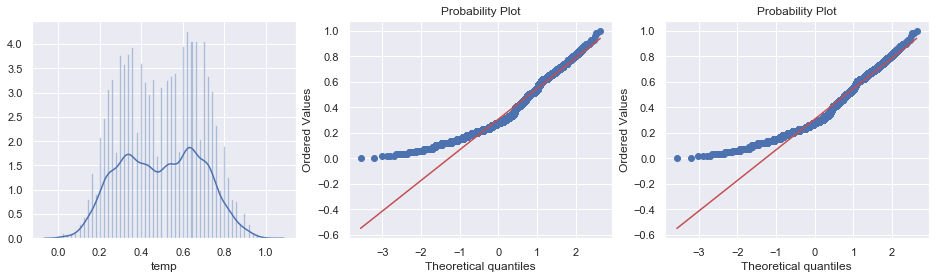

In [37]:
# Zoom-in to temperatur: not perfectly Gaussian, slightly bimodal. Linear regression assumes normal distribution.
# Not a problem by itself but we need to check how the residuals are distributed after the regression.
fig = plt.figure()
ax = fig.add_subplot(131)
sns.distplot(df['temp'], bins=100)

ax = fig.add_subplot(132)
x = stats.loggamma.rvs(c=2.5, size=500)
stats.probplot(df['atemp'], dist=stats.loggamma, sparams=(2.5,), plot=ax)

ax = fig.add_subplot(133)
stats.probplot(df['atemp'], dist=stats.loggamma, sparams=(2.5,), plot=ax)
plt.subplots_adjust(right=2.2)
plt.savefig('Distribution_QQplot_temperature.png', bbox_inches = 'tight')

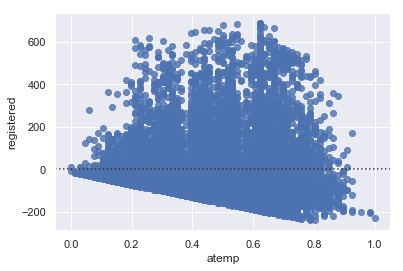

In [40]:
#residuals not evely distributed
sns.residplot(df['atemp'], y=df['registered'])
plt.savefig('Temp_reg_residuals')

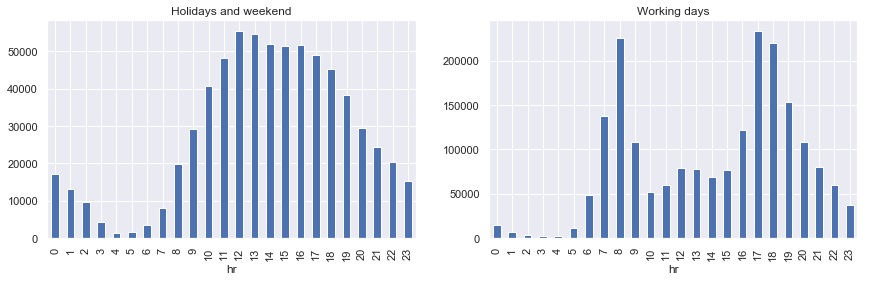

In [39]:
# distribution of bike rentals on holidays vs working days - rush hours vary significantly
fig2 = plt.figure()
ax = fig2.add_subplot(121)
df[df['workingday']==0].groupby(['hr']).sum()['registered'].plot.bar()
plt.title('Holidays and weekend')

ax = fig2.add_subplot(122)
df[df['workingday']==1].groupby(['hr']).sum()['registered'].plot.bar()
plt.title('Working days')
plt.subplots_adjust(right=2)
plt.savefig('Rush_hour.png', bbox_inches = 'tight')

### Step 3. Data wrangling 

In [9]:
print(f'''Number of registered users in third quantile of the hourly mean on weekends {
            df[df['workingday']==0]. groupby(['hr']).mean()['registered'].quantile([0.75])}\n''')         
print(f'''Number of registered users in third the quantile of the hourly mean on workdays {
            df[df['workingday']==1].groupby(['hr']).mean()['registered'].quantile([0.75])}''') 

Number of registered users in third quantile of the hourly mean on weekends 0.75    209.430736
Name: registered, dtype: float64

Number of registered users in third the quantile of the hourly mean on workdays 0.75    224.956437
Name: registered, dtype: float64


In [10]:
# tranform dates to pandas datetime format
df['date'] = pd.to_datetime(df['dteday'])
df['week_nr'] = df['date'].dt.week 

In [11]:
# change season names to string format, season scale does not have equal intervals, one-hot encode the feaure (create dummies)
df['season_name'] = df['season'].map({1:'winter', 2:'spring', 3:'summer', 4:'autumn'})
season_dummies = pd.get_dummies(df['season_name'])
df = pd.DataFrame.join(df, season_dummies, how='outer')

In [12]:
# one-hot encode weather situation
df['weatherclass'] = df['weathersit'].map({1:'clear', 2:'cloudy', 3:'rainy', 4:'stormy'})
weather_dummies = pd.get_dummies(df['weatherclass'])
df= pd.DataFrame.join(df, weather_dummies, how='outer')

In [13]:
# one-hot encode hours
dummies_hr = pd.get_dummies(df['hr'], drop_first=True)
df = pd.DataFrame.join(df, dummies_hr, how='outer')

In [14]:
print(f'''Number of registered users in third quantile of the hourly mean on weekends {
            df[df['workingday']==0]. groupby(['hr']).mean()['registered'].quantile([0.75])}\n''')         
print(f'''Number of registered users in third the quantile of the hourly mean on workdays {
            df[df['workingday']==1].groupby(['hr']).mean()['registered'].quantile([0.75])}''') 


Number of registered users in third quantile of the hourly mean on weekends 0.75    209.430736
Name: registered, dtype: float64

Number of registered users in third the quantile of the hourly mean on workdays 0.75    224.956437
Name: registered, dtype: float64


In [15]:
def weekend_workday_rush(df):
    """
    Create separate lists of rush hour dummie variables for weekends and weekdays taking the rental 
    mean of third quantile hourly average, 1 for rush hour 0 for regular hour
    """
    we_rush = []
    wd_rush = []
    for i, j in zip(df['workingday'], df['registered']):
        if i==0 and j>=209:
            we_rush.append(1), wd_rush.append(0)
        elif i==0 and j<209:
            we_rush.append(0), wd_rush.append(0)
        elif i==1 and j>=225:
            wd_rush.append(1), we_rush.append(0)
        else:
            wd_rush.append(0), we_rush.append(0)
    return wd_rush, we_rush

df['workday_rush'], df['weekend_rush'] = weekend_workday_rush(df)

### Step 5. Fitting a model

####  5.1. Linear Regression
PS! Statsmodel works with Scipy version 1.2.1, might need to downgrade the version.

In [17]:
# Split the data - input variables have been chosen by trial error from the OLS regression results for their significance
X = df[['spring', 'autumn','summer', 'hum', 'atemp', 'clear', 'cloudy', 'workingday', 'workday_rush','weekend_rush', 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22]]
y = df['registered']
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y)

#### Linear regression from StatsModel

In [19]:
m_OLS = sm.OLS(np.array(ytrain), sm.add_constant(Xtrain))
result = m_OLS.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.803
Model:                            OLS   Adj. R-squared:                  0.802
Method:                 Least Squares   F-statistic:                     1765.
Date:                Sun, 14 Jul 2019   Prob (F-statistic):               0.00
Time:                        12:17:51   Log-Likelihood:                -73309.
No. Observations:               13034   AIC:                         1.467e+05
Df Residuals:                   13003   BIC:                         1.469e+05
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            8.3695      4.623      1.811      0.070      -0.692      17.431
spring          13.7711      2.115      6.512      0.000       9.626      17.916
autumn          29.5943      1.869     15.835      0.000      25.931      33.258
summer          13.1243      2.654      4.945      0.000       7.921      18.327
hum            -37.7699      3.993     -9.459      0.000     -45.597     -29.943
atemp          100.1874      5.843     17.147      0.000      88.734     111.640
clear           24.7309      2.448     10.102      0.000      19.932      29.530
cloudy          23.4228      2.439      9.602      0.000      18.641      28.204
workingday      16.2073      1.489     10.886      0.000      13.289      19.126
workday_rush   217.3103      2.093    103.806      0.000     213.207     221.414
weekend_rush   142.2666      2.705     52.586      0.000     136.964     147.570
1              -47.3997      3.216    -14.738      0.000     -53.704     -41.095
2              -54.4718      3.216    -16.940      0.000     -60.775     -48.169
3              -63.2322      3.280    -19.280      0.000     -69.661     -56.804
4              -66.6935      3.300    -20.211      0.000     -73.162     -60.225
5              -52.9853      3.262    -16.243      0.000     -59.379     -46.591
7               30.0057      3.334      8.999      0.000      23.470      36.542
8              137.6942      3.438     40.047      0.000     130.955     144.434
9               38.4722      3.320     11.589      0.000      31.965      44.979
10              31.2906      3.246      9.640      0.000      24.928      37.653
11              38.4958      3.268     11.781      0.000      32.091      44.901
12              43.4602      3.338     13.022      0.000      36.918      50.002
13              38.7360      3.355     11.544      0.000      32.159      45.313
14              42.3549      3.329     12.723      0.000      35.830      48.880
15              34.9882      3.417     10.241      0.000      28.291      41.685
16              34.6844      3.453     10.044      0.000      27.916      41.453
17             149.0510      3.498     42.614      0.000     142.195     155.907
18             135.1402      3.484     38.791      0.000     128.311     141.969
19              53.3279      3.392     15.723      0.000      46.680      59.976
20              33.0998      3.271     10.119      0.000      26.688      39.511
22              23.9251      3.181      7.522      0.000      17.690      30.160
==============================================================================
Omnibus:                     2323.631   Durbin-Watson:                   1.969
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8375.168
Skew:                           0.874   Prob(JB):                         0.00
Kurtosis:    

[0]

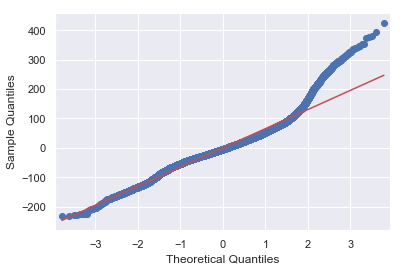

In [41]:
# Data fails normality Q-Q plot test - OLS might no be the best model here, we might be able to improve
sm.qqplot(result.resid, line='r')
plt.savefig('OLS_QQplot.png')
[0]

#### Linear regression from sklearn

In [21]:
# Technically same as OLS from statsmodels library but statsmodel gives us more statistical information about the regression
m = LinearRegression()
m.fit(Xtrain, ytrain)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [22]:
# Training and test scores are close, model does a good job
print(f'R-squared:{m.score(Xtrain, ytrain)}')
print(f'Cross-validation accuracy mean: {cross_val_score(m, Xtrain, ytrain, cv=5).mean()}')
print(f'Model accuracy on test data: {m.score(Xtest, ytest)}')

R-squared:0.8028611047264813
Cross-validation accuracy mean: 0.8013497194821501
Model accuracy on test data: 0.8000527547914839


#### 5.2. Regularized Linear Regression
We have a high number of features and there is too high correlation between some of the features.  
The problem can be alleviated by introducing a penalty term.   

Bias-variance tradeoff: 
 * Lower R-squared -> our model has more bias than baseline LinearRegression without L1 norm but we are overfitting less

In [23]:
X_reg = df[['autumn', 'hum', 'atemp', 'workday_rush','weekend_rush', 1, 2, 3, 4, 5,  8,   17, 18]]
y_reg = df['registered']
Xtrain_reg, Xtest_reg, ytrain_reg, ytest_reg = train_test_split(X_reg, y_reg)

#### Lasso from sklearn

In [24]:
m_lasso = Lasso(alpha=1.0)
m_lasso.fit(Xtrain_reg, ytrain_reg)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [25]:
result_coef = pd.DataFrame(list(zip(X_reg.columns, m_lasso.coef_)), columns = ['feature', 'coef']).set_index('feature')
result_coef

,coef
feature,
autumn,13.956704
hum,-48.928122
atemp,96.750310
workday_rush,247.355500
weekend_rush,144.545683
1,-41.624425
2,-48.483118
3,-55.751641
4,-60.609381


In [26]:
print(f'R-squared:{m_lasso.score(Xtrain_reg, ytrain_reg)}')
print(f'Cross-validation accuracy mean: {cross_val_score(m_lasso, Xtrain_reg, ytrain_reg, cv=5).mean()}')
print(f'Model accuracy on test data: {m_lasso.score(Xtest_reg, ytest_reg)}')

R-squared:0.7795489460011342
Cross-validation accuracy mean: 0.7788598184365005
Model accuracy on test data: 0.7828004323495992


#### Lasso from StatsModel 

In [65]:
# lasso helps us to remove the 0 coefs -> they don't provide value to our model
model_lasso = sm.OLS(np.array(ytrain_reg), sm.add_constant(Xtrain_reg, prepend=True)) # prepend adds intercept to first place
result_lasso = model_lasso.fit_regularized(alpha=1.0, L1_wt=1.0, refit=True) # we refit the model to see the coefficients
print(result_lasso.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.790
Model:                            OLS   Adj. R-squared:                  0.790
Method:                 Least Squares   F-statistic:                     3508.
Date:                Sun, 14 Jul 2019   Prob (F-statistic):               0.00
Time:                        12:53:30   Log-Likelihood:                -73770.
No. Observations:               13034   AIC:                         1.476e+05
Df Residuals:                   13020   BIC:                         1.477e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           74.8647      2.818     26.564   

### Step 6. Answer to the initial problem
Which features have the highest impact in terms of the bike rental by registered users?

In [28]:
def plot_outcome(columns, coefficients):
    Xtrain_columns = pd.DataFrame({'Xtrain_columns':columns})
    Correl_coef = pd.DataFrame({'Correl_coef':coefficients})
    Xtrain_columns = pd.DataFrame.join(Xtrain_columns, Correl_coef, how='outer')

    Xtrain_columns.set_index('Xtrain_columns', inplace=True)
    Xtrain_columns.plot.bar(figsize=(10,5))
    plt.xlabel('Features', fontsize=13)
    plt.ylabel('Coefficients', fontsize=13)

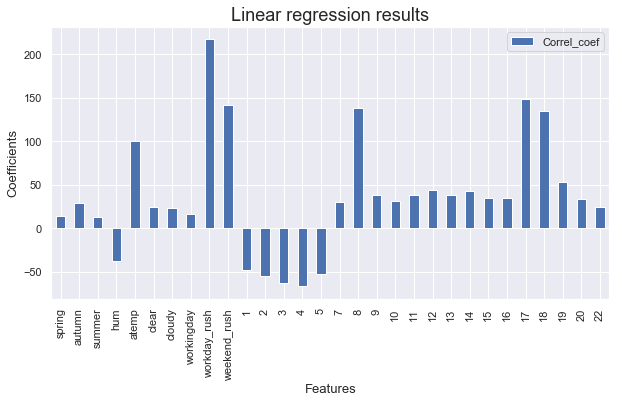

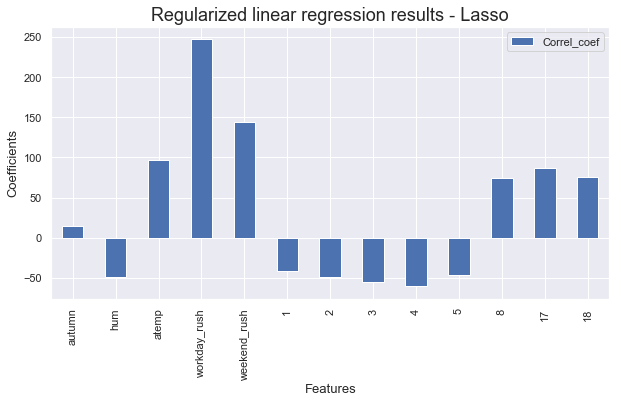

In [43]:
plot_outcome(Xtrain.columns, m.coef_)
plt.title('Linear regression results', fontsize=18)
plt.savefig('Result_LinReg')

plot_outcome(Xtrain_reg.columns, m_lasso.coef_)
plt.title('Regularized linear regression results - Lasso', fontsize=18)
plt.savefig('Result_Lasso')

### Step 7. Summarize results:    
Inferences from the data:   
* From the resuts we can say that the registered user are most affected by the rushhour and temperature features.
* Rushhour - more likely to rent a bike
* humidity high, on rainy days the users are avoiding biking
* the warmer the weather the more likely are the registered users to use the bike rental service   

A business could use this information to introduce for example surge pricing or increase the marketing efforts at the right season. 